In [21]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [22]:
@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector.
    y_ptr,  # *Pointer* to second input vector.
    output_ptr,  # *Pointer* to output vector.
    n_elements,  # Size of the vector.
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
                 # NOTE: `constexpr` so it can be used as a shape value.
):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)


In [23]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output


In [34]:
def test():
    torch.manual_seed(0)
    size = 98432
    x = torch.rand(size, dtype=torch.float16, device='cuda')
    y = torch.rand(size, dtype=torch.float16, device='cuda')
    output_torch = x + y
    output_triton = add(x, y)
    print(output_torch)
    print(output_triton)
    print(
        f'The maximum difference between torch and triton is '
        f'{torch.max(torch.abs(output_torch - output_triton))}'
    )

test()


tensor([1.3711, 1.3076, 0.4939,  ..., 0.6680, 1.1982, 1.2695], device='cuda:0',
       dtype=torch.float16)
tensor([1.3711, 1.3076, 0.4939,  ..., 0.6680, 1.1982, 1.2695], device='cuda:0',
       dtype=torch.float16)
The maximum difference between torch and triton is 0.0


In [36]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2 ** i for i in range(12, 30, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)


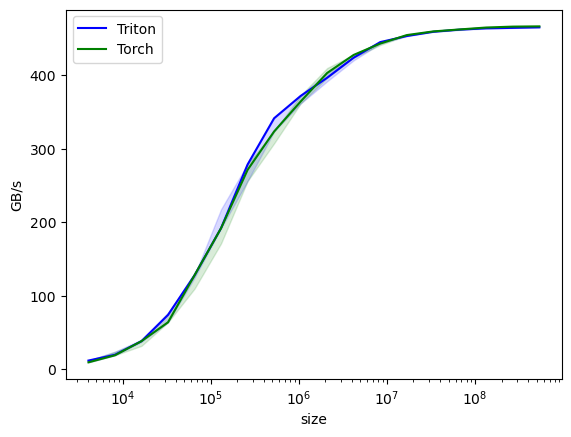

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000    9.600000
1        8192.0   19.883495   19.200000
2       16384.0   38.400001   38.400001
3       32768.0   74.024091   63.999998
4       65536.0  127.999995  127.999995
5      131072.0  192.000000  192.000000
6      262144.0  278.481578  271.183452
7      524288.0  341.333321  323.368435
8     1048576.0  371.659727  364.088903
9     2097152.0  396.387102  402.885254
10    4194304.0  423.724127  427.408686
11    8388608.0  444.814490  442.810806
12   16777216.0  453.046438  454.355168
13   33554432.0  458.861940  459.364487
14   67108864.0  461.792119  462.050708
15  134217728.0  463.561451  464.657026
16  268435456.0  464.177059  465.876315
17  536870912.0  464.931729  466.224269


In [37]:
benchmark.run(print_data=True, show_plots=True)


In [31]:
torch.rand(3, dtype=torch.float16)


tensor([0.5938, 0.4077, 0.3726], dtype=torch.float16)